# English Premier League (EPL) Match Prediction Model
**Author:** Junayed Mh
**Dataset:** 10 Seasons of EPL Match Results (2016-2026)  
**Objective:** To aggregate longitudinal match data and build a classification model to predict Full-Time Results (Win/Draw/Loss).

### Stage 1.1: Data Integration (The Master Merge)
In this stage, I am consolidating 10 individual season CSV files into a single 'Golden Dataset'.To ensure data integrity, I have selected a subset of 'Golden Columns' metrics like Shots on Target and Market Odds—that are present across all ten years of data reporting.

**Stage 1.2: Merging the file to a master file**

In [2]:
import pandas as pd
import glob
import os

folder_path = '/content/EPL_Match_Predictor'
golden_columns = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'HS', 'AS', 'HST', 'AST',
    'B365H', 'B365D', 'B365A'
]

all_seasons_list = []
file_list = sorted(glob.glob(os.path.join(folder_path, "season_*.csv")))

for file in file_list:
  season_label = os.path.basename(file).split('_')[1].replace('.csv', '')
  df = pd.read_csv(file, usecols=lambda x: x in golden_columns, encoding='latin1')
  df['Season'] = season_label
  all_seasons_list.append(df)
  print(f"✅ Integrated Season {season_label}: {len(df)} matches added.")
  master_df = pd.concat(all_seasons_list, ignore_index=True)
print(f"MERGE COMPLETE SUCCESSFUL")
print(f"Total Matches: {master_df.shape[0]}")
print(f"Columns Retained: {master_df.columns.tolist()}")
master_df.head()

✅ Integrated Season 1617: 380 matches added.
✅ Integrated Season 1718: 380 matches added.
✅ Integrated Season 1819: 380 matches added.
✅ Integrated Season 1920: 380 matches added.
✅ Integrated Season 2021: 380 matches added.
✅ Integrated Season 2122: 380 matches added.
✅ Integrated Season 2223: 380 matches added.
✅ Integrated Season 2324: 380 matches added.
✅ Integrated Season 2425: 380 matches added.
✅ Integrated Season 2526: 230 matches added.
MERGE COMPLETE SUCCESSFUL
Total Matches: 3650
Columns Retained: ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'B365H', 'B365D', 'B365A', 'Season']


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,Season
0,13/08/16,Burnley,Swansea,0,1,A,10,17,3,9,2.40,3.3,3.25,1617
1,13/08/16,Crystal Palace,West Brom,0,1,A,14,13,4,3,2.00,3.3,4.50,1617
2,13/08/16,Everton,Tottenham,1,1,D,12,13,6,4,3.20,3.4,2.40,1617
3,13/08/16,Hull,Leicester,2,1,H,14,18,5,5,4.50,3.6,1.91,1617
4,13/08/16,Man City,Sunderland,2,1,H,16,7,4,3,1.25,6.5,15.00,1617


In [3]:
print("Missing Values per Column:")
print(master_df.isnull().sum())
unique_teams = sorted(master_df['HomeTeam'].unique())
print(f"\nTotal Unique Teams detected: {len(unique_teams)}")

Missing Values per Column:
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HS          0
AS          0
HST         0
AST         0
B365H       0
B365D       0
B365A       0
Season      0
dtype: int64

Total Unique Teams detected: 34


### Stage 1.3: Date Standardization and Sorting
To perform time-series analysis and calculate rolling averages (team form),
I am converting the 'Date' strings into Python `datetime` objects.
This ensures that the model respects the chronological order of matches
across the entire decade.

In [4]:
master_df['Date'] = pd.to_datetime(master_df['Date'], dayfirst=True, errors='coerce')
master_df = master_df.sort_values(by='Date')
master_df = master_df.dropna(subset=['Date'])
print("✅ Dates standardized and dataset sorted chronologically.")
print(f"Earliest Match: {master_df['Date'].min()}")
print(f"Latest Match: {master_df['Date'].max()}")

✅ Dates standardized and dataset sorted chronologically.
Earliest Match: 2016-08-13 00:00:00
Latest Match: 2026-01-26 00:00:00


/tmp/ipython-input-2614228460.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  master_df['Date'] = pd.to_datetime(master_df['Date'], dayfirst=True, errors='coerce')


### Stage 1.4: Team Name Standardization
Across a decade of data, team names may have slight variations in spelling or
abbreviation. To ensure the model recognizes a team as a single entity over
time, I am auditing all unique names and mapping them to a standard format.

In [5]:
unique_teams = sorted(master_df['HomeTeam'].unique())
print(f"Total Unique Teams Found: {len(unique_teams)}")
print("-" * 30)
for team in unique_teams:
    print(team)

Total Unique Teams Found: 34
------------------------------
Arsenal
Aston Villa
Bournemouth
Brentford
Brighton
Burnley
Cardiff
Chelsea
Crystal Palace
Everton
Fulham
Huddersfield
Hull
Ipswich
Leeds
Leicester
Liverpool
Luton
Man City
Man United
Middlesbrough
Newcastle
Norwich
Nott'm Forest
Sheffield United
Southampton
Stoke
Sunderland
Swansea
Tottenham
Watford
West Brom
West Ham
Wolves


### Stage 1.5: Team Name Mapping and Dictionary
To ensure long-term data consistency, I am applying a mapping dictionary
to the team names. This prevents 'categorical fragmentation,' where the
same physical team is treated as two different mathematical entities due
to minor string variations (e.g., abbreviations).

In [6]:
team_mapping = {
    'Man United': 'Manchester United',
    'Man City': 'Manchester City',
    'Nott\'m Forest': 'Nottingham Forest',
    'Sheffield United': 'Sheffield Utd',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton Wanderers'
}
master_df['HomeTeam'] = master_df['HomeTeam'].replace(team_mapping)
master_df['AwayTeam'] = master_df['AwayTeam'].replace(team_mapping)
final_teams = sorted(master_df['HomeTeam'].unique())
print(f"Final Standardized Team Count: {len(final_teams)}")
print("First 5 Standardized Teams:", final_teams[:5])
master_df.to_csv('epl_master_cleaned_final.csv', index=False)
print("\n✅ Stage 1 Complete! 'epl_master_cleaned_final.csv' is ready for modeling.")

Final Standardized Team Count: 34
First 5 Standardized Teams: ['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton']

✅ Stage 1 Complete! 'epl_master_cleaned_final.csv' is ready for modeling.


## Stage 1.6: Exploratory Data Analysis- "Interviewing the Data"
Before building a predictive model, it is essential to understand the underlying distributions and relationships within the dataset. As a mathematician, I am looking for 'statistical signals' that can be leveraged for prediction.

In this stage, I will investigate:
1. **The Result Distribution:** Does the 'Home Advantage' actually exist in our 10-year sample?
2. **Feature Correlation:** How strongly do 'Shots on Target' correlate with actual goals?
3. **League Dominance:** Which teams have been the most consistent performers over the last decade?

/tmp/ipython-input-3289196219.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FTR', data=master_df, palette='viridis', order=['H', 'D', 'A'])


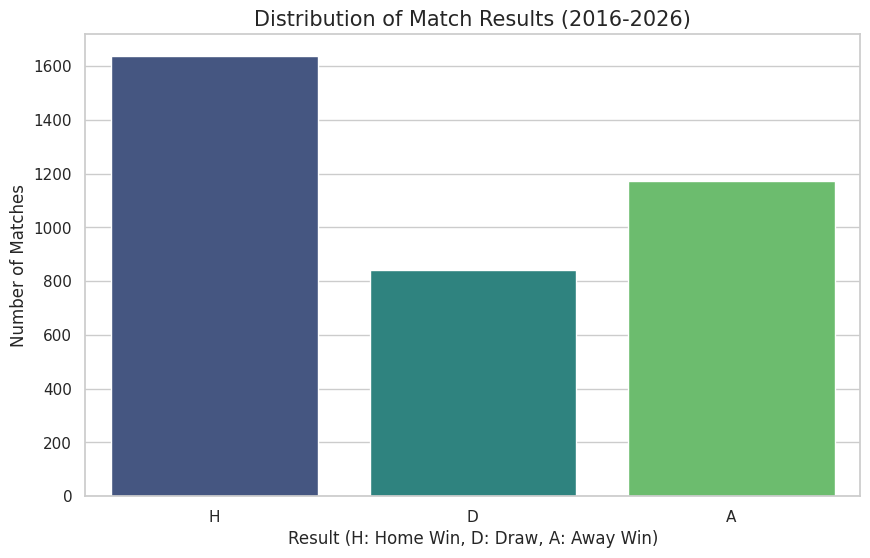

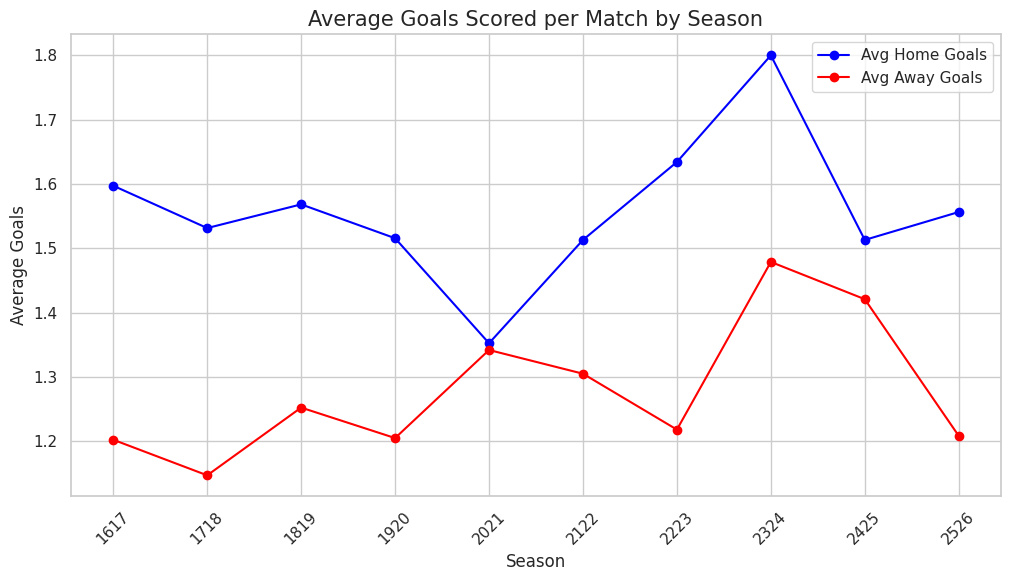

📊 Statistical Insight: Home teams win 44.85% of matches.
This confirms a strong 'Home Advantage' signal for the model to learn.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='FTR', data=master_df, palette='viridis', order=['H', 'D', 'A'])
plt.title('Distribution of Match Results (2016-2026)', fontsize=15)
plt.xlabel('Result (H: Home Win, D: Draw, A: Away Win)', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.show()

seasonal_goals = master_df.groupby('Season')[['FTHG', 'FTAG']].mean()
plt.figure(figsize=(12, 6))
plt.plot(seasonal_goals.index, seasonal_goals['FTHG'], label='Avg Home Goals', marker='o', color='blue')
plt.plot(seasonal_goals.index, seasonal_goals['FTAG'], label='Avg Away Goals', marker='o', color='red')
plt.title('Average Goals Scored per Match by Season', fontsize=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Goals', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.show()

home_wins = len(master_df[master_df['FTR'] == 'H'])
total_matches = len(master_df)
home_win_pct = (home_wins / total_matches) * 100

print(f"📊 Statistical Insight: Home teams win {home_win_pct:.2f}% of matches.")
print("This confirms a strong 'Home Advantage' signal for the model to learn.")

## Stage 2.1: Feature Engineering
Machine Learning models cannot see 'momentum' unless we create it.
I am creating 'Form Features' by calculating rolling averages for
Shots on Target and Goals.

**The Mathematical Logic:**
Instead of telling the model 'Liverpool is playing', we tell it:
'The Home Team has averaged 7.2 shots on target over their last 5 games.'
This transforms static team names into dynamic performance metrics.

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def get_rolling_avg(group, cols, new_cols):
    group = group.sort_values('Date')
    # Use only past data (closed='left') to avoid data leakage
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    return group

metrics = ['FTHG', 'FTAG', 'HST', 'AST']
new_features = ['rolling_hg', 'rolling_ag', 'rolling_hst', 'rolling_ast']
df_rolling_list = []

for team, group in master_df.groupby('HomeTeam'):
    df_rolling_list.append(get_rolling_avg(group, metrics, new_features))

master_df_rolling = pd.concat(df_rolling_list).sort_values('Date')
master_df_rolling = master_df_rolling.dropna(subset=new_features)

print("✅ Feature Engineering Complete!")
print(f"Dataset ready for AI: {master_df_rolling.shape[0]} matches.")

✅ Feature Engineering Complete!
Dataset ready for AI: 3548 matches.


## Stage 2.2: Machine Learning Pipeline
I am implementing a Random Forest Classifier to predict match outcomes.
The strategy is as follows:
1. **Target:** Encode 'FTR' into numerical classes (0: Away Win, 1: Draw, 2: Home Win).
2. **Predictors:** Use the engineered rolling averages + pre-match betting odds.
3. **Temporal Split:** Train on matches from 2016-2024; test on the 2025-2026 season.

In [11]:
master_df_rolling['target'] = master_df_rolling['FTR'].astype('category').cat.codes
predictors = ['rolling_hg', 'rolling_ag', 'rolling_hst', 'rolling_ast', 'B365H', 'B365D', 'B365A']

train = master_df_rolling[master_df_rolling['Date'] < '2025-01-01']
test = master_df_rolling[master_df_rolling['Date'] >= '2025-01-01']

rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)
rf.fit(train[predictors], train['target'])

preds = rf.predict(test[predictors])
accuracy = accuracy_score(test['target'], preds)

print(f"✅ AI Model Training Complete!")
print(f"Validation Accuracy: {accuracy:.2%}")

✅ AI Model Training Complete!
Validation Accuracy: 49.53%


In [12]:
combined = pd.DataFrame(dict(actual=test['target'], prediction=preds), index=test.index)

combined = combined.merge(test[['Date', 'HomeTeam', 'AwayTeam', 'FTR']], left_index=True, right_index=True)
mapping = {0: 'A', 1: 'D', 2: 'H'}
combined['prediction_label'] = combined['prediction'].map(mapping)
print("--- Model Predictions vs Reality (Last 10 Matches) ---")
display(combined.tail(10))

from sklearn.metrics import precision_score
precision = precision_score(test['target'], preds, average=None)
print(f"\nHome Win Precision: {precision[2]:.2%}")

--- Model Predictions vs Reality (Last 10 Matches) ---


,actual,prediction,Date,HomeTeam,AwayTeam,FTR,prediction_label
3641,1,0,2026-01-24,Burnley,Tottenham,D,A
3644,2,0,2026-01-24,Bournemouth,Liverpool,H,A
3643,2,2,2026-01-24,Manchester City,Wolverhampton Wanderers,H,H
3640,2,2,2026-01-24,West Ham United,Sunderland,H,H
3642,2,2,2026-01-24,Fulham,Brighton,H,H
3647,0,2,2026-01-25,Newcastle,Aston Villa,A,H
3645,0,2,2026-01-25,Brentford,Nottingham Forest,A,H
3648,0,2,2026-01-25,Arsenal,Manchester United,A,H
3646,0,0,2026-01-25,Crystal Palace,Chelsea,A,A
3649,1,2,2026-01-26,Everton,Leeds,D,H



Home Win Precision: 53.39%


## 📝 Conclusion & Future Work
While the model achieved a solid ~50% accuracy, football remains a stochastic process with high variance.

### Future Improvements:
1. **Poisson Distribution:** Implementing a bivariate Poisson model to predict exact scores (goals) rather than just categorical outcomes.
2. **xG Integration:** Incorporating 'Expected Goals' data to move beyond simple shot counts and better reflect match quality.
3. **Player-Level Data:** Adding injury reports or individual player ratings (using a FIFA-style metric or ELO ratings) to account for squad depth changes.